In [1]:
import tensorflow as tf
import pandas as pd
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

data = pd.read_csv('Data/image_pixels_augmented.csv').astype('float32')
data.head()



,255,255.1,254,253,250,249,251,254.1,251.1,253.1,...,244.14,255.409,252.47,253.76,252.48,255.410,254.131,252.49,255.411,255.412
0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,...,255.0,253.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
1,255.0,248.0,255.0,255.0,252.0,252.0,255.0,253.0,255.0,253.0,...,249.0,251.0,255.0,255.0,252.0,253.0,252.0,254.0,253.0,250.0
2,255.0,249.0,253.0,255.0,250.0,250.0,252.0,244.0,255.0,255.0,...,253.0,251.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
3,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0
4,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,254.0,255.0,255.0


In [2]:
width, height, channel = 32, 32, 1   # 이미지사이즈 32*32 

x = data.values
x = x.reshape((x.shape[0], width, height, channel))

print(x.shape)

(9962, 32, 32, 1)


In [3]:
# normalization [0,255] >> [-1,1]
x = (x-127.5) / 127.5
print(x[0][0][:5])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


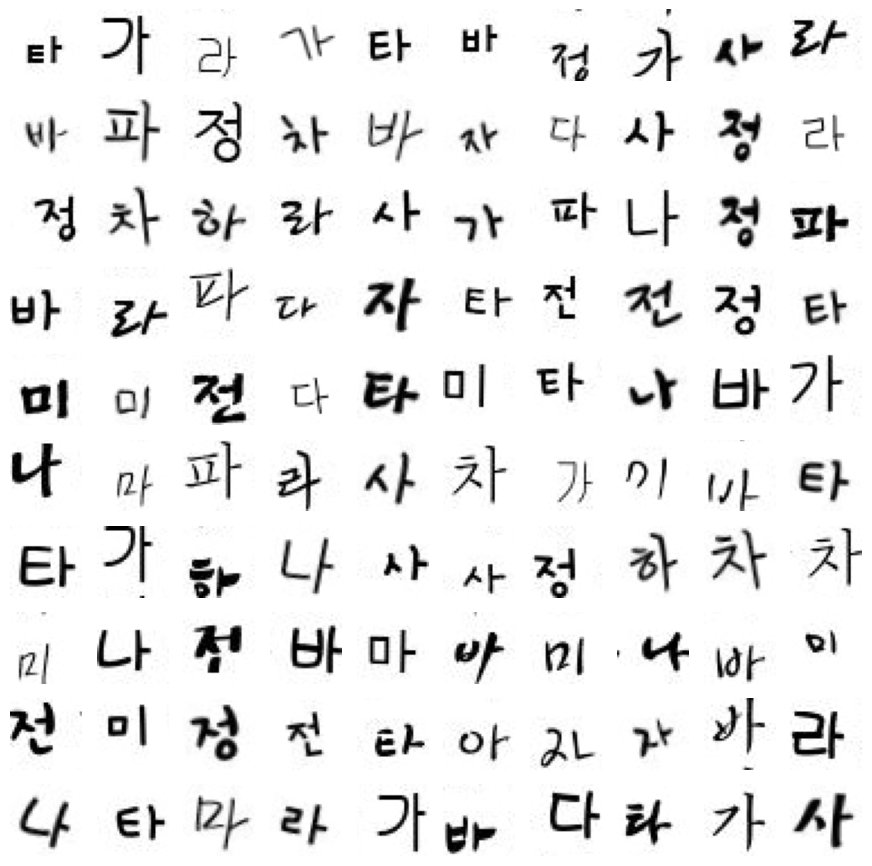

In [4]:
import matplotlib.pyplot as plt  

plt.figure(figsize=(11,11))
i = 1
for image in x:
    plt.subplot(10, 10, i)   # (10*10)
    image = image.reshape(width, height)
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    i += 1
    if i > 100:
        break

plt.show()

In [5]:
# 학습용데이터

BATCH_SIZE = 64
train_dataset = tf.data.Dataset.from_tensor_slices(x).shuffle(x.shape[0]).batch(BATCH_SIZE)
print(train_dataset)

<BatchDataset element_spec=TensorSpec(shape=(None, 32, 32, 1), dtype=tf.float32, name=None)>


In [6]:
# 생성모형
from tensorflow.keras.layers import Dense, BatchNormalization, LeakyReLU, Reshape, Conv2DTranspose
from tensorflow.keras import Sequential

def build_generator_model():
    model = Sequential()
    model.add(Dense(1024, input_dim=100))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Dense(8*8*128))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Reshape((8,8,128)))
              
    model.add(Conv2DTranspose(128, (5,5), strides=(1,1), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(64, (5,5), strides=(2,2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', activation='tanh'))
    assert model.output_shape == (None, 32, 32, 1)
    return model

generator = build_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1024)              103424    
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 8192)              8396800   
                                                                 
 batch_normalization_1 (Batc  (None, 8192)             32768     
 hNormalization)                                                 
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 8192)              0

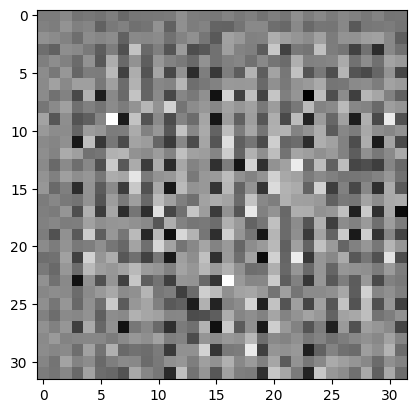

In [7]:
# 학습되지 않은 생성 모델이 만든 이미지

import os    
os.environ['KMP_DUPLICATE_LIB_OK']='True'

noise = tf.random.normal([1,100])
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0,:,:,0], cmap='gray')
            # [0  : 배치 차원, 배치크기가 1이므로 0번인덱스 사용
            # ,0] : 흑백이미지 

In [23]:
noise

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 0.1072915 ,  1.475987  , -0.39267898,  0.66731507,  0.15732375,
         0.3892885 ,  0.99823606, -0.13556151, -0.41246474,  0.12494065,
        -1.6813929 , -0.50526726, -0.20636235, -0.15675388, -0.5361825 ,
        -1.1157439 , -0.33075222,  0.20553188, -0.13685644,  0.39231423,
         1.2570096 ,  0.181978  , -0.0602349 , -0.5455585 ,  0.342175  ,
         0.21234924,  2.0969915 ,  0.9068459 , -0.03445902, -0.2911175 ,
         1.1185002 , -2.2779548 ,  0.58389515,  0.02242103, -0.24050505,
        -0.2666489 ,  1.0949389 , -0.8420562 , -0.79037315, -1.5310504 ,
        -1.0803226 , -1.6034708 ,  0.5260785 , -1.1246277 ,  0.97959286,
         0.6921553 ,  1.4764599 , -0.74173963, -2.3887527 ,  0.07873546,
         1.1854765 ,  0.524809  ,  0.44161925, -0.43559602,  1.1771768 ,
         1.1188154 ,  0.04124687, -1.6914722 ,  0.45566568,  0.6988099 ,
        -0.6604829 , -0.7438921 , -2.1158485 ,  0.29756105, -0.49530658,
 

In [24]:
generator(noise, training = False)


<tf.Tensor: shape=(1, 32, 32, 1), dtype=float32, numpy=
array([[[[0.9982507 ],
         [0.9996161 ],
         [0.99966335],
         ...,
         [0.9998405 ],
         [0.9999134 ],
         [0.99928844]],

        [[0.9999419 ],
         [0.99987   ],
         [0.9999477 ],
         ...,
         [0.99999297],
         [0.9999613 ],
         [0.99946934]],

        [[0.9999824 ],
         [0.9998577 ],
         [0.9998395 ],
         ...,
         [1.        ],
         [0.9999985 ],
         [0.99991906]],

        ...,

        [[0.9991379 ],
         [0.9983268 ],
         [0.99752724],
         ...,
         [0.9999607 ],
         [0.999995  ],
         [0.99998623]],

        [[0.99942726],
         [0.9985668 ],
         [0.999063  ],
         ...,
         [0.999634  ],
         [0.9999361 ],
         [0.9998939 ]],

        [[0.99970734],
         [0.999582  ],
         [0.9997098 ],
         ...,
         [0.9999537 ],
         [0.9999452 ],
         [0.9997067 ]]]], dtype

In [27]:
generated_image[:,:,:,0].shape, generated_image[:,:,:,0]

(TensorShape([1, 32, 32]),
 <tf.Tensor: shape=(1, 32, 32), dtype=float32, numpy=
 array([[[-4.3152664e-05,  1.7514970e-04,  7.3859938e-03, ...,
           4.2476966e-03, -4.3358514e-03, -3.5732004e-03],
         [ 3.0279197e-03,  7.3255971e-04,  1.2659267e-02, ...,
          -1.1927162e-03, -1.3488252e-04, -4.5090336e-03],
         [ 1.1361350e-02,  8.5365083e-03,  3.2253538e-03, ...,
           2.0653175e-02,  6.6810120e-03, -1.6588338e-02],
         ...,
         [ 8.6841490e-03,  5.5748797e-03,  7.7270330e-03, ...,
           1.0409356e-02,  3.1025151e-02, -8.8294707e-03],
         [ 5.2276803e-03, -4.1410378e-03,  2.2298532e-02, ...,
          -9.5010037e-03,  1.0958942e-02,  3.9233831e-03],
         [ 1.3250997e-04, -3.7411910e-03,  5.8510695e-03, ...,
          -1.5454791e-02,  2.4859365e-02, -8.0734864e-03]]], dtype=float32)>)

In [28]:
generated_image[0,:,:,0].shape, generated_image[0,:,:,0]

(TensorShape([32, 32]),
 <tf.Tensor: shape=(32, 32), dtype=float32, numpy=
 array([[-4.3152664e-05,  1.7514970e-04,  7.3859938e-03, ...,
          4.2476966e-03, -4.3358514e-03, -3.5732004e-03],
        [ 3.0279197e-03,  7.3255971e-04,  1.2659267e-02, ...,
         -1.1927162e-03, -1.3488252e-04, -4.5090336e-03],
        [ 1.1361350e-02,  8.5365083e-03,  3.2253538e-03, ...,
          2.0653175e-02,  6.6810120e-03, -1.6588338e-02],
        ...,
        [ 8.6841490e-03,  5.5748797e-03,  7.7270330e-03, ...,
          1.0409356e-02,  3.1025151e-02, -8.8294707e-03],
        [ 5.2276803e-03, -4.1410378e-03,  2.2298532e-02, ...,
         -9.5010037e-03,  1.0958942e-02,  3.9233831e-03],
        [ 1.3250997e-04, -3.7411910e-03,  5.8510695e-03, ...,
         -1.5454791e-02,  2.4859365e-02, -8.0734864e-03]], dtype=float32)>)

In [29]:
generated_image[0,:,:,:].shape, generated_image[0,:,:,:]

(TensorShape([32, 32, 1]),
 <tf.Tensor: shape=(32, 32, 1), dtype=float32, numpy=
 array([[[-4.3152664e-05],
         [ 1.7514970e-04],
         [ 7.3859938e-03],
         ...,
         [ 4.2476966e-03],
         [-4.3358514e-03],
         [-3.5732004e-03]],
 
        [[ 3.0279197e-03],
         [ 7.3255971e-04],
         [ 1.2659267e-02],
         ...,
         [-1.1927162e-03],
         [-1.3488252e-04],
         [-4.5090336e-03]],
 
        [[ 1.1361350e-02],
         [ 8.5365083e-03],
         [ 3.2253538e-03],
         ...,
         [ 2.0653175e-02],
         [ 6.6810120e-03],
         [-1.6588338e-02]],
 
        ...,
 
        [[ 8.6841490e-03],
         [ 5.5748797e-03],
         [ 7.7270330e-03],
         ...,
         [ 1.0409356e-02],
         [ 3.1025151e-02],
         [-8.8294707e-03]],
 
        [[ 5.2276803e-03],
         [-4.1410378e-03],
         [ 2.2298532e-02],
         ...,
         [-9.5010037e-03],
         [ 1.0958942e-02],
         [ 3.9233831e-03]],
 
        [

In [8]:
# 판별모형
from tensorflow.keras.layers import Conv2D, Dropout, Flatten

def build_discriminator_model():
    model = Sequential()

    model.add(Conv2D(64, (5, 5), strides=2, padding='same', input_shape=[32,32,1]))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=2, padding='same'))
    model.add(LeakyReLU(0.2))
    
    model.add(Flatten())

    model.add(Dense(256))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.3))

    model.add(Dense(1))

    return model

discriminator = build_discriminator_model()
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 64)        1664      
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 16, 16, 64)        0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 128)         204928    
                                                                 
 leaky_re_lu_5 (LeakyReLU)   (None, 8, 8, 128)         0         
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense_2 (Dense)             (None, 256)              

In [9]:
# 학습되지 않은 판별 모형의 결과
predicted = discriminator(generated_image)
print(predicted)

tf.Tensor([[0.00063827]], shape=(1, 1), dtype=float32)


In [10]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# 최적화함수(생성 모형)
generator_optimizer = Adam(1e-4)

# 최적화함수(판별 모형)
discriminator_optimizer = Adam(1e-4)

# 손실함수
cross_entropy = BinaryCrossentropy(from_logits=True)


In [17]:
# 생성모델 목표: 판별 모델이 가짜 이미지를 판별했을 때 판별값이 1에 가까워지도록 하는 것
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

def discriminator_loss(real_output, fake_output):
    # 1과 real_image 비교: real_image의 판별값이 1에 가까워지도록 함
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    # 0과 fake_image 비교: fake_image의 판별값이 0에 가까워지도록 함
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss
    

In [18]:
##### GradientTape() 자동미분 예제
w = tf.Variable(tf.random.normal((3, 2)), name='w') #3행 2열의 난수
b = tf.Variable(tf.zeros(2, dtype=tf.float32), name='b')
print('w:', w)
print('b:',  b)

x = [[1., 2., 3.]]

with tf.GradientTape() as tape: # with 구문 내의 연산 내용 기록
  y = x @ w + b # x@w 행렬곱
  print('y:',y)
  loss = tf.reduce_mean(y**2)

[dl_dw, dl_db] = tape.gradient(loss, [w, b])  
print('df_dw, dl_db:' , [dl_dw, dl_db])

w: <tf.Variable 'w:0' shape=(3, 2) dtype=float32, numpy=
array([[ 1.9583176 , -1.9052408 ],
       [ 2.0092497 ,  0.23788615],
       [-0.03768952, -0.7841553 ]], dtype=float32)>
b: <tf.Variable 'b:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>
y: tf.Tensor([[ 5.8637486 -3.7819345]], shape=(1, 2), dtype=float32)
df_dw, dl_db: [<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[  5.8637486,  -3.7819345],
       [ 11.727497 ,  -7.563869 ],
       [ 17.591246 , -11.345803 ]], dtype=float32)>, <tf.Tensor: shape=(2,), dtype=float32, numpy=array([ 5.8637486, -3.7819345], dtype=float32)>]


In [19]:
# 학습파라미터
EPOCHS = 300
noise_dim = 100

def train_step(images):
    # 생성모델 input noise
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    # Gradient descent 계산 및 파라미터 업데이트
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # 자동미분
        generated_images = generator(noise, training=True)

        # real image 판별값
        real_output = discriminator(images, training=True)

        # fake image 판별값
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [20]:
from IPython.display import clear_output
import time

# noise visualization

test_noise = tf.random.normal([100, noise_dim])

def show_generated_images(epoch):
    images = generator.predict(test_noise)
    images = 0.5*images + 0.5

    plt.figure(figsize = (11,11))
    i = 1 
    for image in images:
        image = image.reshape(width, height)
        plt.subplot(10, 10, i)
        plt.imshow(image, cmap='gray')
        plt.axis('off')

        i+=1
    plt.suptitle(f'EPOCH: {epoch}', fontsize=25)
    plt.savefig(f'image_at_epoch_{epoch:04d}.png')
    plt.show()
    clear_output(wait=True)
    time.sleep(0.5)

In [21]:
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:   # mini batch
            train_step(image_batch)
        print('%s epochs trained' % epoch)
        show_generated_images(epoch)

In [22]:
train(train_dataset, EPOCHS)
generator.save('Data/result/korean_number_gen_test.h5')